In [13]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft
from io import BytesIO

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [14]:
k = 3   # kernel size
beta2s = [1, 0, 0.25, 0.5, 0.75] #[0, 0.25, 0.75, 1]  
activations = [tf.nn.relu]
timestamps = [1,25, 100]
experiment_name = "unipolar_circle"
box_dims = [200, 100]
step =   25 # Plot axis step

In [15]:
tf.nn.relu.__name__

'relu'

In [16]:
3//2

1

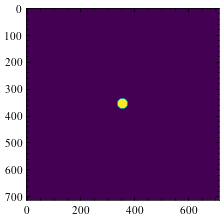

In [17]:
# Single pixel input
d = 715
mid = d//2

img = np.zeros((d,d)) # cv2.imread('input4.png', 0)/255. 


cv2.circle(img,(mid,mid), 19, (255.0), -1)
mid = img.shape[0]//2

plt.imshow(img)

In [18]:
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
filters = np.zeros((3,3,1,1))
img = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32)

In [ ]:
import matplotlib.patches as mpatches



filters = np.zeros((3,3,1,1))



#Get image height and width

vals_x = img[0, img.shape[1]//2, :, :]
vals_y = img[0, :, img.shape[2]//2, :]
nonzeros = np.nonzero(vals_x)[0]
if nonzeros.size > 0:
    length_y = nonzeros[-1] - nonzeros[0] + 1
else:
    length_y = 0  # all zeros
nonzeros = np.nonzero(vals_x)[0]
if nonzeros.size > 0:
    length_x = nonzeros[-1] - nonzeros[0] + 1
else:
    length_x = 0  # all zeros



#step = 2**np.floor(np.log2(( (length_x) + np.max(timestamps) )// 5))


max_x = int(box_dims[0]*(.75))
min_x = -int(box_dims[0]*(.25))

max_y = box_dims[1]//2
min_y = -(box_dims[1]//2)

print(max_y, min_y)
print(length_x, length_y)


for activation in activations:
	directory = f"figures/{experiment_name}_{activation.__name__}_{k}x{k}"
	if not os.path.exists(directory):
		os.makedirs(directory)


	for beta2 in beta2s:

		
		images = []

		filters = np.zeros((3,3,1,1))

		t = np.zeros((3,3))
		t[1, 0] = np.sqrt(beta2)
		t[0, 0] = np.sqrt(1-beta2)
		filters = np.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1)) 
		print(tf.math.reduce_euclidean_norm(filters))
		#filters /= tf.math.reduce_euclidean_norm(filters)
		
		w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)
		w = tf.transpose(w, perm=(1,0,2,3))


		x = img





		#Generate Plot
		fig = plt.figure(figsize=(16,len(timestamps)+1))
		gs = fig.add_gridspec(1,len(timestamps)+1, wspace=0.1)

		'''ax0 = fig.add_subplot(gs[0], projection='3d')
		plot_filter_x(beta2, ax = ax0)
		ax0.axis('off')'''

		#for i, im in enumerate(images):	
		plot_num = 1
		for i in range(timestamps[-1]+1):
			x = x/np.std(x)
			
			if i in timestamps:

				ax = fig.add_subplot(gs[plot_num])
				plot_num+=1
				print(np.std(x))
				vals = x[0, x.shape[1]//2, :, :]
				vals = vals/np.sum(vals)

				pos = np.expand_dims(np.linspace(-(x.shape[1]//2), x.shape[1]//2, x.shape[1]),-1)
				mean = tf.reduce_sum(pos*vals)
				var = tf.reduce_sum(((pos-mean)**2) * vals)
				std = np.sqrt(var)
				#print(mean, np.sqrt(var))
				
				im = ax.imshow(x[0,:,:,0])
				ax.plot(mid, mid, marker = '+', color='red')

				'''arr =  mpatches.FancyArrowPatch((mid, mid), (mid+mean+std, mid),
										mutation_scale=4, shrinkA=0, shrinkB=0,zorder=10, color="red")
				ax.add_patch(arr)'''


				ax.annotate(r'$\sigma_x=$'+f"{std:.2f}", (0.05,0.01), ha='left', va='bottom',color='white', xycoords='axes fraction', fontsize=15)
				ax.annotate(r'$\mu_x=$'+f"{mean:.2f}", (0.05,0.14), ha='left', va='bottom',color='white', xycoords='axes fraction', fontsize=15)
				#ax.annotate(r'$argmax_x=$'+f"{np.argmax(vals)-mid:.2f}", (0.05,.17), ha='left', va='bottom',color='white', xycoords='axes fraction')
				
				#ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 6), xycoords=arr, ha='center', va='bottom',color='white')
				#ax.arrow(, 112, dx=, dy= 0, color='black')




				ax.set(xlim=((mid + min_x, mid+max_x)) , ylim=((mid+min_y, (mid+max_y))))

				# Re-label ticks relative to midpoint
				xticks = ax.get_xticks()
				yticks = ax.get_yticks()

				#ax.set_xticklabels(np.arange(min_x, max_x+1, step=2))
				#ax.set_yticklabels(np.arange(min_y, max_y+1, step=2))
				xticks = np.arange(np.sign(min_x) * (np.abs(min_x)//2)*2, step+(max_x//2)*2, step=step) + mid
				yticks = np.arange(np.sign(min_y) * (np.abs(min_y)//2)*2, step+(max_y//2)*2, step=step) + mid
				ax.set_xticks(xticks)
				ax.set_yticks(yticks)
				ax.tick_params(axis='x', labelsize=15)
				ax.tick_params(axis='y', labelsize=15)


				ax.set_xticklabels([x - mid for x in xticks])
				ax.set_yticklabels([y - mid for y in yticks])



				#ax.set_xticks(np.linspace(-round(std)-1, round(std)+1, int(0.5*(std)+3)))
				#fig.colorbar(im, orientation='vertical')

				'''plt.close(fig) 
				buf = BytesIO()
				fig.savefig(buf, format="svg", dpi=fig.dpi, bbox_inches="tight")
				buf.seek(0)'''



				#ax0.imshow(im)
				#ax.axis('off')
				if beta2 == 0:
					ax.set_title(f"t={i}", fontsize=25)


				#images.append(Image.open(buf))
				#print(x)

			x = activation( tf.nn.conv2d(x, w , strides=(1,1), 
									padding='SAME') )
			print(np.max(x))


		fig.subplots_adjust(left=0.02, right=0.98, top=0.9, bottom=0.01, wspace=0.1)
		fig.savefig(os.path.join(directory, f"{experiment_name}_{k}x{k}__{activation.__name__}_{beta2}.pdf"), format="pdf", dpi=fig.dpi, bbox_inches="tight")
		plt.show()


50 -50
39 39
tf.Tensor(0.9999999999999999, shape=(), dtype=float64)
26.090633
0.9999988
120.93401
146.99825
164.37839
177.53223
187.93034
196.52583
203.95659
210.46198
216.26044
221.43224
226.09674
230.25824
233.98505
237.31125
240.26836
242.88866
245.1739
247.15488
248.85611
250.29721
251.49933
252.47638
253.25098
253.84094
1.0000005
254.26802
254.5411
254.67924
254.69696
254.61076
254.42848
254.16359
253.82646
253.42795
252.97472
252.47508
251.93655
251.36482
250.76491
250.14172
249.50037
248.84349
248.17468
247.49713
246.81276
246.12392
245.43214
244.73969
244.04744
243.3566
242.66824
241.98306
241.30177
240.62508
239.9532
239.28671
238.62593
237.97104
237.32222
236.67972
236.04353
235.41383
234.79063
234.17395
233.56375
232.95987
232.36267
231.77194
231.18759
230.60957
230.0378
229.47223
228.91273
228.35933
227.81183
227.27023
226.7344
226.2043
225.67978
225.16055
224.64703
224.13885
223.63596
223.13828
222.64565
222.15807
221.67543
221.19771
220.72473
220.25645
219.79285
219.33377

In [21]:
xticks-mid

array([-50, -25,   0,  25,  50,  75, 100, 125, 150])

In [22]:
mid

357

In [23]:
yticks#-mid

array([307, 332, 357, 382, 407])

In [24]:
step

25